## Hands on real clustering data - eBOSS LRG (plus BOSS CMASS) sample
In this session we will estimate (and interpret) the correlation function / power spectrum of galaxy catalogs.
This is the first step of a standard clustering analysis; the second step consists in fitting these compressed measurements with a theory model to extract cosmological parameters, which will be explored in the Y2 TD (bao_inverse_distance_ladder.ipynb).

In [1]:
import numpy as np

from astropy.table import Table

import environment
from environment import Measurement  # specify paths

## Inspecting catalogs

Download eBOSS LRGpCMASS catalogs here: https://drive.google.com/drive/folders/1bs0YSEwCOghx2YzCb2IbdIkn-7uttQz-?usp=sharing
  
(These are a "light version" of the official catalogs provided at https://data.sdss.org/sas/dr16/eboss/lss/catalogs/DR16/)

In [2]:
tracer = 'LRGpCMASS'
cap = 'NGC'
recon = False
# base_dir is the directory where you saved the catalogs
path_data, path_randoms = environment.path_catalogs(tracer=tracer, cap=cap, recon=recon, base_dir='./catalogs/lite')

In [3]:
data = Table.read(path_data)
randoms = Table.read(path_randoms)
data.columns
randoms.columns

<TableColumns names=('RA','DEC','Z','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','NZ','WEIGHT_FKP')>

Galaxies (and randoms) in the catalog receive weights, to correct for observational systematic effects, such that the ensemble average of galaxy density (= "survey selection function") and that of randoms match:
- WEIGHT_SYSTOT: weights to correct for photometric systematics: what are they? non-cosmological variations of target density (due to e.g. galactic dust, varying atmospheric, sky conditions)
- WEIGHT_CP: weights to correct for fiber collisions: what are they? all galaxies do not receive a spectroscopic fibers (due to the limited density of fibers)
- WEIGHT_NOZ: weights to correct for redshift failures: what are they? reliable redshifts are not obtained for all galaxies (due to instrumental and observational conditions)

The total (completenes) weight is: WEIGHT_COMP = WEIGHT_SYSTOT * WEIGHT_CP * WEIGHT_NOZ.

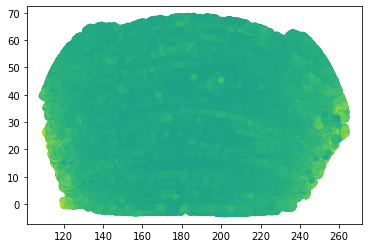

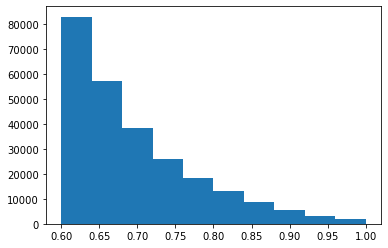

In [4]:
# Make a scatter plot of RA/Dec, histogram as a function of redshift
from matplotlib import pyplot as plt
plt.scatter(data['RA'], data['DEC'], c=data['WEIGHT_SYSTOT'])
plt.show()
plt.hist(data['Z'])
plt.show()

To compute the 3D correlation function or power spectrum, we first need to transform redshifts Z into distances, assuming a fiducial cosmology. Let's take BOSS (and eBOSS) fiducial cosmology:
$\Omega_{m} = 0.31$, $\omega_{b} = 0.022$, $h = 0.676$, $\sigma_{8} = 0.8$, $n_{s} = 0.97$.

In [5]:
# Fiducial cosmological parameters are:
# dict(Omega_m=0.31, omega_b=0.022, h=0.676, sigma8=0.8, n_s=0.97)
# To compute comoving_radial_distance(z), various options:
# 1) code this yourself if you have never done so!
# H(z) = H_{0} \sqrt{\Omega_{m} (1 + z)^3 + \Omega_{\Lambda}}
# d(z) = \int cdz / H(z)
# WARNING: let's work in Mpc/h units (H0 = 100 h km/s/Mpc)
# 2) use classy, camb, astropy...
# 3) use cosmoprimo (engine='class' or 'camb' or 'astropy'), see cell 9 of https://github.com/cosmodesi/cosmoprimo/blob/main/nb/examples.ipynb
from cosmoprimo import Cosmology
cosmo_fid = Cosmology(Omega_m=0.31, omega_b=0.022, h=0.676, sigma8=0.8, n_s=0.97, engine='class')
# Or simply:
#from cosmoprimo.fiducial import BOSS
#cosmo_fid = BOSS(engine='class')
# Compute vector of data positions (RA, DEC, d(Z))
data_positions = [data['RA'], data['DEC'], cosmo_fid.comoving_radial_distance(data['Z'])]
# Same for randoms
randoms_positions = [randoms['RA'], randoms['DEC'], cosmo_fid.comoving_radial_distance(randoms['Z'])]

In addition to completeness weights above, you can apply weights to minimize variance: WEIGHT_FKP = 1/(1 + NZ * P0), with P0 the typical value of the power spectrum at the scales of interest, e.g. $10000 \; (\mathrm{Mpc}/h)^{3}$ (NZ is in $(\mathrm{Mpc}/h)^{3}$).
See e.g. https://arxiv.org/pdf/astro-ph/9304022.pdf, eq. 2.3, for the variational demonstration (another, broader point-of-view is that of the optimal quadratic estimator, of which the FKP estimator we will use below is a simplification under some assumptions).

In [6]:
# Compute data weights, WEIGHT_COMP * WEIGHT_FKP
for cat in [data, randoms]:
    cat['WEIGHT_COMP'] = cat['WEIGHT_SYSTOT'] * cat['WEIGHT_CP'] * cat['WEIGHT_NOZ']
data_weights = data['WEIGHT_COMP'] * data['WEIGHT_FKP']
# Same for randoms
randoms_weights = randoms['WEIGHT_COMP'] * randoms['WEIGHT_FKP']

## Correlation function

### Pair counts as a function of $(s, \mu)$

Correlation functions are typically estimated binning the (weighted) number of pairs of particles (galaxies, randoms) as a function of the separation $s$ between particles (and optionally the cosine angle to the line-of-sight $\mu$).

This is basically a double loop, schematically:

for i1 in n1:  
    for i2 in n2:  
        counts[index(s(i1, i2)), index(mu(i1, i2))] += weight(i1, i2)  

For n1 ~ n2 ~ O(1e6) objects, this will be slow (especially in Python). How to speed this up?
Auto pair counts can be compute ~ twice faster than cross pair counts, how?

In [7]:
# Compute galaxy - galaxy pair counts DD
# You can use pycorr (wrapping a modified version of Corrfunc)
# If so, take a quick look at https://github.com/cosmodesi/pycorr/blob/main/nb/basic_examples.ipynb
edges = (np.linspace(0., 200, 201), np.linspace(-1., 1., 100))  # s, mu binning
from pycorr import TwoPointCounter
# If positions are x, y, z, pass position_type='xyz' instead
D1D2 = TwoPointCounter(mode='smu', edges=edges, positions1=data_positions, weights1=data_weights,
                       position_type='rdd', nthreads=4, dtype='f8', engine='corrfunc')
# D1D2.sep are (average) separations
# D1D2.wcounts are pair counts (weighted by the product of particle weights)
# D1D2.wnorm is the normalization (see below)
# Same for randoms - randoms pair counts RR
R1R2 = TwoPointCounter(mode='smu', edges=edges, positions1=randoms_positions, weights1=randoms_weights,
                       position_type='rdd', nthreads=4, dtype='f8', engine='corrfunc')

Can you guess how RR counts typically evolve as a function of $s$ at small separation? This relation is not perfect at small scales, due to fine-grained veto masks, but why is it really not valid anymore at large scales? You see now why randoms are important!

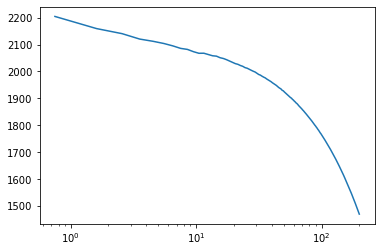

In [8]:
# Plot RR / f(s) counts as a function of s
plt.plot(R1R2.sep.mean(axis=-1), R1R2.wcounts.sum(axis=-1) / (R1R2.edges[0][1:]**3 - R1R2.edges[0][:-1]**3))
plt.xscale('log')
plt.show()
# Drops at large scale due to finite survey size / non-periodic boundary conditions

### Natural estimator
The natural estimator (the simplest one can typically think of) for the correlation function compares the (weighted) number of galaxy pairs to that of randoms (what we would have in absence of clustering), i.e. DD / RR - 1, with:
- DD the (normalized) galaxy - galaxy pair counts
- RR the (normalized) randoms - randoms pair counts
Why 'normalized'? What is the normalization factor?

In [9]:
# Compute DD / RR - 1
# WARNING: you need to normalize DD and RR first! By what factor?
D1D2_wnorm = np.sum(data_weights)**2 - np.sum(data_weights**2)
R1R2_wnorm = np.sum(randoms_weights)**2 - np.sum(randoms_weights**2)
xi = D1D2.wcounts / D1D2_wnorm / (R1R2.wcounts / R1R2_wnorm) - 1
sep = np.sum(R1R2.sep * R1R2.wcounts, axis=-1) / np.sum(R1R2.wcounts, axis=-1)

### Multipoles of the correlation function
Compute and plot the correlation function multipoles $\ell = 0$ (monopole), $\ell = 2$ (quadrupole) and $\ell = 4$ (hexadecapole), given by $\xi_{\ell}(s) = \frac{2 \ell + 1}{2} \int_{-1}^{1} d\mu \xi(s,\mu) \mathcal{L}_{\ell}(\mu)$,
with $\mathcal{L}_{\ell}(\mu)$ Legendre polynomials (see https://en.wikipedia.org/wiki/Legendre_polynomials, also https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.legendre.html).

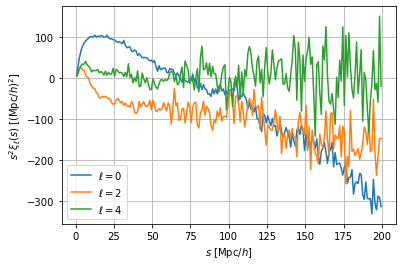

In [10]:
# Trick: write d\mu \mathcal{L}_{\ell}(\mu) as the difference of \mathcal{L}_{\ell}(\mu) primitives
# This makes sure $\xi_{\ell > 0} is 0 in case $\xi(s,\mu)$ is constant in \mu
ells = (0, 2, 4)
# Compute xiell, list of multipoles
# Compute sep, mean s
from scipy import special
xiell = []
for ell in ells:
    muedges = R1R2.edges[1]
    poly = special.legendre(ell).integ()(muedges)
    legendre = (2 * ell + 1) * (poly[1:] - poly[:-1])
    xiell.append(np.sum(xi * legendre, axis=-1) / (muedges[-1] - muedges[0]))

# Plot the correlation function multipoles
for ill, ell in enumerate(ells):
    plt.plot(sep, sep**2 * xiell[ill], label='$\ell = {:d}$'.format(ell))
plt.grid(True)
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^{2}\xi_{\ell}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.legend()
plt.show()

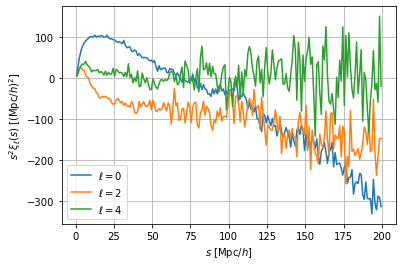

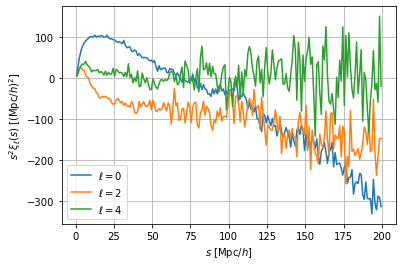

In [11]:
# Notes about pycorr
# You can obtain this directly with:
from pycorr import NaturalTwoPointEstimator
estimator = NaturalTwoPointEstimator(D1D2=D1D2, R1R2=R1R2)
s, xiell = estimator(ells=ells, return_sep=True)
estimator.plot(ells=ells)
# Or, starting from the beginning:
from pycorr import TwoPointCorrelationFunction
estimator = TwoPointCorrelationFunction(mode='smu', edges=edges, data_positions1=data_positions, data_weights1=data_weights,
                                        randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                        estimator='natural', position_type='rdd', nthreads=4, dtype='f8', engine='corrfunc')
estimator.plot(ells=ells)
plt.show()

The monopole looks odd on large scales! No worries, this is not bias (in average, it would be fine), but the natural estimator has a larger variance than the Landy-Szalay estimator (see e.g. https://articles.adsabs.harvard.edu/pdf/1993ApJ...412...64L): (DD - 2DR + RR) / RR.
Estimate the correlation function with the Landy-Szalay estimator.

In [12]:
# You can compute all pair counts DD, DR and RR as above
# Or use pycorr's general interface (see https://github.com/cosmodesi/pycorr/blob/main/nb/basic_examples.ipynb)
#from pycorr import TwoPointCorrelationFunction
#estimator = TwoPointCorrelationFunction(mode='smu', edges=edges, ...)
from pycorr import TwoPointCorrelationFunction
estimator = TwoPointCorrelationFunction(mode='smu', edges=edges, data_positions1=data_positions, data_weights1=data_weights,
                                        randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                        estimator='landyszalay', position_type='rdd', nthreads=4, dtype='f8', engine='corrfunc')

Plot the correlation function multipoles. Looks better!  
You should clearly see the BAO peak (where?) You can compare data to a theory correlation function.

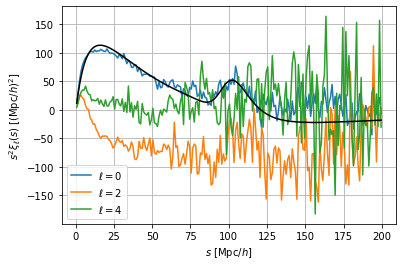

In [13]:
# Plot
estimator.plot(ells=ells)
zeff = np.average(data['Z'], weights=data_weights)  # (quite arbitrary) effective redshift
kaiser_factor = 6.5 # scaling by hand, just to match the amplitude
xi_model = kaiser_factor * cosmo_fid.get_fourier().pk_interpolator().to_xi()(sep, z=zeff)
plt.plot(sep, sep**2 * xi_model, color='k')
plt.show()

What does the non-zero quadrupole mean? Where does it come from?

## Power spectrum

Computing pair counts for correlation function estimation remains somewhat slow (still tractable for current surveys, DESI, Euclid). Also, theoreticians tend to prefer the power spectrum, as k-modes evolve independently in the linear regime (see Julien's course).
Let's compute the power spectrum monopole step-by-step, to show how this works.

In [14]:
from pypower import CatalogMesh
# Paint catalogs to mesh
# This involves a kernel (resampler='tsc') that effectively smoothes the density field,
# which must be compensated for by a kernel in Fourier space (compensate=True),
# see e.g. https://arxiv.org/abs/astro-ph/0409240
# Wider is this kernel, better is the mitigation of aliasing effects (greater than Nyquist frequencies contaminating lower frequencies)
# Another technique to mitigate aliasing is 'interlacing': shifting the mesh by a fraction of mesh cell size
# see e.g. https://arxiv.org/abs/1512.07295
mesh = CatalogMesh(data_positions=data_positions, data_weights=data_weights,
                   randoms_positions=randoms_positions, randoms_weights=randoms_weights,
                   boxsize=5000., nmesh=256, resampler='tsc', interlacing=3, position_type='rdd',
                   dtype='f8', mpiroot=0)
rfield = mesh.to_mesh(compensate=True)

In [15]:
# The power spectrum is (up to some normalization), the square modulus of the Fourier-space field: P(k) ~ |F(k)|^2
cfield = rfield.r2c()  # Fast Fourier Transform, F(r) -> F(k)
cfield[...] = cfield[...] * cfield[...].conj()
del rfield  # save memory
#print(cfield.value[0, 0, 0])  0 by construction: integral constraint!

# Now, bin as a function of |k|
# edges = (k-edges, mu-edges)
knyq = np.pi * np.min(mesh.nmesh / mesh.boxsize)  # Nyquist frequency
edges = (np.arange(0., knyq, 0.005), np.linspace(-1., 1., 2))
from pypower.fft_power import project_to_basis
k, _, pk, nk, _ = project_to_basis(cfield, edges)[0]
k, pk = k.ravel(), pk.ravel().real
del cfield  # save memory

In [16]:
# Let's find the normalization
# FFT convention is F(k) = 1/N^3 \sum_{r} e^{-ikr} F(r), so compensate by N^6
pk *= mesh.nmesh.prod()**2
# Then, we will typically normalize by something close to 1/dV \sum_{r} \bar{F}^2(r)
# Trick: data * randoms instead of randoms**2 to avoid shot noise
wnorm = (mesh.to_mesh(field='data', compensate=False) * mesh.to_mesh(field='data-normalized_randoms', compensate=False)).csum() / np.prod(mesh.boxsize / mesh.nmesh)
pk /= wnorm

Plot the power spectrum (typically $k P(k)$). What is its unit?
The small scales (high $k$) monopole looks fishy (too high), did we forget anything?

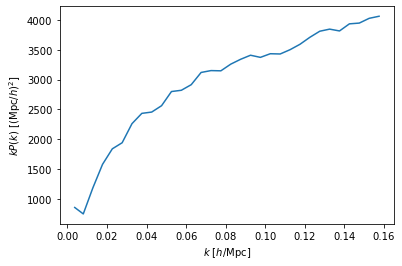

In [17]:
plt.plot(k, k * pk)
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

Indeed, we forgot to remove the Poisson shot noise! What is it?
It is computed as $1/A (\sum_{i \in \mathrm{data}} w_{i}^{2} + \alpha^2 \sum_{i \in \mathrm{randoms}} w_{i}^{2}$, with $\alpha = \sum_{i \in \mathrm{data}} w_{i} / \sum_{i \in \mathrm{randoms}} w_{i})$.
Subtract it from the esimated power spectrum, and plot the result.

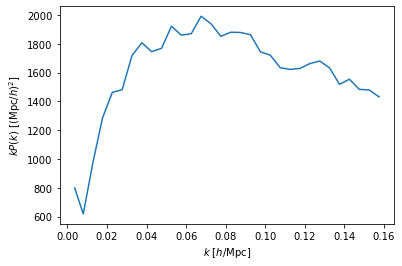

In [18]:
# Plot
alpha = np.sum(data_weights) / np.sum(randoms_weights)
shotnoise = (np.sum(data_weights**2) + alpha**2 * np.sum(randoms_weights**2)) / wnorm
plt.plot(k, k * (pk - shotnoise))
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

Looks much better! Do you recognize the BAO wiggles? To see them better, you can compare data to a theory power spectrum.

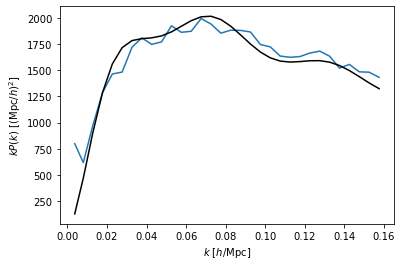

In [19]:
# Plot
pk_model = kaiser_factor * cosmo_fid.get_fourier().pk_interpolator()(k, z=zeff)
plt.plot(k, k * (pk - shotnoise))
plt.plot(k, k * pk_model, color='k')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

### Multipoles of the power spectrum
Estimating higher multipoles (quadrupole, hexadecapole) is slightly more difficult, as we have to account for varying line-of-sight. We typically use the first-point / end-point for line-of-sight $\eta$, to split:
$\hat{P}(k) = 1 / A \sum_{r_{1}, r_{2}} e^{ik(r_{2} - r_{1})} F(r_{1}) F(r_{2}) \mathcal{L}_{\ell}(k \cdot \eta)$
into:
$\hat{P}(k) = 1 / A F(k)^{\star} F_{\ell}(k)$
with:
$F_{\ell}(k) = \sum_{r} e^{ikr} F(r) \mathcal{L}_{\ell}(k \cdot r)$
This last term can be split, using e.g. decomposition of Legendre polynomial into spherical harmonics, into a pure k-dependent term, times a standard Fourier transform, which can be FFTed. See e.g. https://arxiv.org/abs/1704.02357.

In [20]:
# For this, use pypower.
# (You can take a quick look at https://github.com/cosmodesi/pypower/blob/main/nb/basic_examples.ipynb)
from pypower import CatalogFFTPower
power = CatalogFFTPower(data_positions1=data_positions, data_weights1=data_weights,
                        randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                        boxsize=5000., nmesh=256, resampler='tsc', interlacing=3,
                        edges={'step': 0.005}, ells=(0, 2, 4), position_type='rdd', dtype='f8', mpiroot=0).poles

Plot the power spectrum multipoles.
Again, BAO wiggles and non-zero quadrupole!

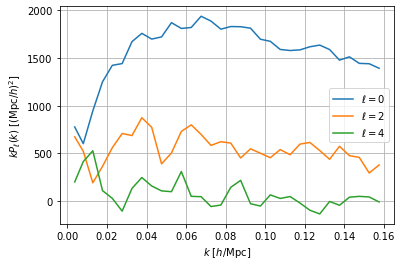

In [21]:
# Plot
power.plot()
plt.show()

Note that the above power spectrum measurements (using the 'FKP estimator') cannot (should not) be directly compared to theory power spectrum models... Indeed, in these measurements the power spectrum is convolved with the survey selection function (that we essentially already removed in the correlation function estimation with the division by RR). Therefore, usually people multiply the theory power spectrum by the window matrix, which can be computed from the random catalogs; see https://github.com/cosmodesi/pypower/blob/main/nb/window_examples.ipynb if you are interested.

### Kaiser formula
Still, let's just look how the power spectrum multipoles compare to the Kaiser formula, which gives the expected power spectrum in the linear approximation:
$P(k, \mu) = (b + f \mu^2)^{2} P^{\mathrm{lin}}(k) = (\beta^{-1} + \mu^2)^{2} P^{\mathrm{lin}}_{\theta\theta}(k)$ ($\beta = f / b$)
where $b$ is the galaxy bias, $f = \frac{d\ln{D}}{d\ln{a}} \simeq \Omega_m(z)^{0.55}$ is the logarithmic growth rate of structure, $P^{\mathrm{lin}}(k)$ is the linear power spectrum.

The model depends on $f (\times \sigma_{8})$ or --- better formulated --- the amplitude of the velocity divergence power spectrum $P_{\theta\theta}(k)$, which we can fit to the data.

Integrate $P(k, \mu)$ over Legendre polynomials, either symbolically (easy!) or by numerical integration, and plot model and data.

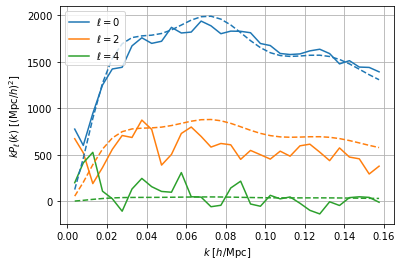

In [22]:
pklin = cosmo_fid.get_fourier().pk_interpolator()(k, z=zeff)
f = cosmo_fid.growth_rate(zeff)
b = 2.25  # tune by hand to match data amplitude
pk_model = []
# Append the multipoles
pk_model.append((b**2 + 2. / 3. * b * f + 1. / 5. * f**2) * pklin)
pk_model.append((4. / 3. * b * f + 4. / 7. * f**2) * pklin)
pk_model.append(8. / 35 * f**2 * pklin)
power.plot()
for ill, ell in enumerate(ells):
    plt.plot(k, k * pk_model[ill], color='C{:d}'.format(ill), linestyle='--')
plt.show()
# Or:
#pktt = cosmo_fid.get_fourier().pk_interpolator(of='theta_cb')(k, z=zeff)
#beta = cosmo_fid.growth_rate(zeff) / 2.25  # tune by hand
#pk_model = []
# Append the multipoles
#pk_model.append((1 / beta**2 + 2. / 3. / beta + 1. / 5.) * pktt)
#pk_model.append((4. / 3. / beta + 4. / 7.) * pktt)
#pk_model.append(8. / 35 * pktt)
#power.plot()
#for ill, ell in enumerate(ells):
#    plt.plot(k, k * pk_model[ill], color='C{:d}'.format(ill), linestyle='--')
#plt.show()

The quadrupole in particular looks a small scales (high $k$) a bit more damped in the data than in the model, why?
Finger-of-God effect.

## Take-home messages
- in standard analyses, the observed (RA, Dec, z) are compressed into power spectrum or correlation function multipoles
- BAO: peak at 100 $\mathrm{Mpc}/h$ in the correlation function, wiggles in the power spectrum
- measuring the position of the BAO peak = measuring a fixed comoving distance ('standard ruler') at a given redshift = constraing the Universe's expansion
- non-zero quadrupole = anisotropy (w.r.t the line-of-sight): redshift-space distortions (linear model: Kaiser formula)
- measuring redshift-space distortions = constraining the amplitude of the velocity power spectrum: growth of structure

## Bonus
- pen-and-paper exercise: derive the Kaiser formula, knowing that:
$\mathbf{s} = \mathbf{r} + v_{z} \hat{\mathbf{z}}$ with $v_{z}(\mathbf{k}) = i f \mathbf{k} / k^{2} \delta_{r}(\mathbf{k})$ (which can be obtained from linear theory)
and mass conservation (mass in redshift space = mass in real space): $\left[1 + \delta_{s}(\mathbf{s})\right]d^{3}s = \left[1 + \delta_{r}(\mathbf{r})\right]d^{3}r$
- we have worked so far with pre-reconstruction catalogs. A step called 'reconstruction' can be used to sharpen the BAO peak. Compute the correlation function and / or power spectrum of reconstructed catalogs (with *rec* in name).
Note that, in this case, you should provide reconstructed data for data_positions and data_weights, reconstructed randoms for shifted_positions and shifted_weights, and pre-reconstruction randoms for randoms_positions, randons_weights. What is the difference w.r.t. pre-reconstruction measurements? (BAO peak, quadrupole?).
- you can try applying reconstruction yourself to pre-reconstruction catalogs with https://github.com/cosmodesi/pyrecon
- here pair weights are simple product of galaxy individual weights... but we can imagine other schemes, e.g. to correctly compensate for fiber collisions: see https://github.com/cosmodesi/pycorr/blob/main/nb/pip_examples.ipynb (and similar correction for power spectrum, https://github.com/cosmodesi/pypower/blob/main/nb/pip_examples.ipynb)
- start Y2 TD, cosmological constraints with BAO: bao_inverse_distance_ladder.ipynb
- why are you still here? go to the beach...